# Explanation of this notebook

This notebook got three purposes:
1. Improve the estimated delivery date given to customers at the purchase moment
2. Predict wether a delivery is gonna be late
3. Use clustering (k-means) to sugest where and how many warehouses to construct

# Introduction

Customers does not only look for online shopping with the best variety of products and best user experience. They are also demanding fast delivery without delays. Throughout the project we have analyzed various hypotheses that might help Olist optimize business critical KPI's that focus on the cutomer, the sellers, and the process of purchasing products, keeping customers, getting the best sellers on the platform, etc. In this last part, we will analyze the potential of maximizing the latent but critical value in the process of delivering the products. Estimation of delivery is both important when the customer is choosing between products and potentially holding delivery date as a decisive factor, and when delivering the physical product to the customer by connecting logistics providers and various sellers. These operational tasks, which is not directly handled by Olist, are critical to Olist's image and how satisfied customers are after shopping on Olist. 

The goal with the following analysis is threefold. First, we are assessing whether there exist a problem in terms of delivering the products to the customers. The delivery performance is analyzed by looking at historical data and how many delays Olist has had thoughout the dataset. Second, we will optimize Olist's estimate of delivery resulting in better decision-making for the customers and higher convenience throughout the later part of the shopping experience. Lastly, we are going to predict whether an order will be delivered in time or too late by classifying an order upon purchase. 

## KPI



Estimated time of delivery
- her kan vi følge to KPI'er, hhv. Customer attention og Customer retention hvis vi kan begynde og reklamere med en hurtig og præcis leveringstid --> så dvs. vi giver dem information om deres leverance inden de køber frem for efter --> øget tilfredshed

Prediction late yes/no
- antallet af forsinkelser er en KPI i sig selv
- deskriptivt forarbejde, som viser hvad der oftest går galt 
- videre arbejde er derefter at kunne gå ind og sige: hvor meget er pakken forsinket
- --> så når vi får et signal om en forsinkelse så skal der SKE NOGET --> betydende faktorer kunne sige noget om.
- ideen er at vi på en eller anden måde skal kunne flagge en ordre og derefter have en toolbox som kan hjælpe med at undgå eller mindske denne forsinkelse, samt informere kunden så snart det opdaget og give dem en præcis prædiktion på en ny leveringsdag. 

# <font color='blue'>Setup 1</font>: Load Libraries

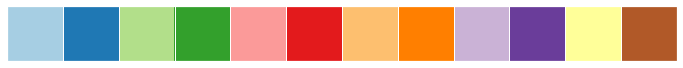

In [79]:
import numpy as np
import pandas as pd
import sys, os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline
sns.set()
sns.palplot(sns.color_palette("Paired"))
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.style.use('ggplot')

# <font color='blue'>Setup 2</font>: Load data

In [2]:
def load_table(tablename):
    """ Defining the current directory and path to where data are located. Joining path to
    data folder and table name in order to read the table into a Pandas DataFrame"""
    
    file_path = os.path.join ('../data/') 

    df = os.path.join(file_path, tablename) 
    df = pd.read_csv(df, sep=',', encoding="latin1") 
    
    return df

In [3]:
# Reading the olist_orders table
orders = load_table('olist_orders_dataset.csv')
order_items = load_table('olist_order_items_dataset.csv')
customers = load_table('olist_customers_dataset.csv')
customers.columns = ['customer_id','customer_unique_id','geolocation_zip_code_prefix',
                     'customer_city','customer_state']
sellers = load_table('olist_sellers_dataset.csv')
sellers.columns = ['seller_id','geolocation_zip_code_prefix',
                     'seller_city','seller_state']
geo = load_table('olist_geolocation_dataset.csv')

In [4]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69
6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85
7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
9,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40


In [5]:
order_items[order_items['order_id']=='8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [6]:
order_items.describe(include='O')

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2018-03-01 02:50:48
freq,21,527,2033,21


In [7]:
order_items_filt = order_items.groupby(['order_id', 'product_id','seller_id','shipping_limit_date','freight_value','price'])['order_item_id'].agg({"quantity":"max"}).reset_index()

/Users/MartinJohnsen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [8]:
order_items_filt['order_price'] = order_items_filt['price']*order_items_filt['quantity']

In [9]:
order_items_filt.describe()

,freight_value,price,quantity,order_price
count,102425.000000,102425.000000,102425.000000,102425.000000
mean,20.111152,124.422006,1.150539,136.778317
std,15.884700,188.926084,0.563005,209.629971
min,0.000000,0.850000,1.000000,0.850000
25%,13.140000,40.000000,1.000000,45.900000
50%,16.320000,78.800000,1.000000,85.000000
75%,21.220000,139.000000,1.000000,149.900000
max,409.680000,6735.000000,21.000000,13440.000000


In [10]:
order_items_filt = order_items_filt.groupby(['order_id','seller_id','shipping_limit_date','freight_value','quantity'])['order_price'].agg('sum').reset_index()

In [11]:
order_items_filt

,order_id,seller_id,shipping_limit_date,freight_value,quantity,order_price
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,13.29,1,58.90
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,19.93,1,239.90
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,17.87,1,199.00
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.79,1,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,18.14,1,199.90
5,00048cc3ae777c65dbb7d2a0634bc1ea,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,12.69,1,21.90
6,00054e8431b9d7675808bcb819fb4a32,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,11.85,1,19.90
7,000576fe39319847cbb9d288c5617fa6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,70.75,1,810.00
8,0005a1a1728c9d785b8e2b08b904576c,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,11.65,1,145.95
9,0005f50442cb953dcd1d21e1fb923495,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,11.40,1,53.99


In [12]:
order_items_filt.describe()

,freight_value,quantity,order_price
count,102425.000000,102425.000000,102425.000000
mean,20.111152,1.150539,136.778317
std,15.884700,0.563005,209.629971
min,0.000000,1.000000,0.850000
25%,13.140000,1.000000,45.900000
50%,16.320000,1.000000,85.000000
75%,21.220000,1.000000,149.900000
max,409.680000,21.000000,13440.000000


# <font color='blue'>Setup 3</font>: Merge datasets

In [13]:
#Looking at the geolocations
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


Since some of the zip-codes has several different geolocations very close to each other, we will aggregate those different locations into a mean location. explain.... 

In [14]:
geo = geo.groupby('geolocation_zip_code_prefix')['geolocation_lat','geolocation_lng'].agg('mean').reset_index()

In [15]:
# Merging geo location to sellers and customers dataset
customers_geo = customers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
customers_geo = customers_geo[['customer_id', 'geolocation_lat','geolocation_lng']]
customers_geo.columns = ['customer_id', 'customer_lat','customer_lon']
#customers_geo = customers_geo.groupby('customer_id')['customer_lat','customer_lon'].agg('mean').reset_index()

sellers_geo = sellers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
sellers_geo = sellers_geo[['seller_id', 'geolocation_lat','geolocation_lng']]
sellers_geo.columns = ['seller_id', 'seller_lat','seller_lon']
#sellers_geo = sellers_geo.groupby('seller_id')['seller_lat','seller_lon'].agg('mean').reset_index()

In [16]:
# Merging geo location to orders dataset
order_items_all = order_items_filt.merge(sellers_geo, on='seller_id', how='left')

orders_all = orders.merge(customers_geo, on='customer_id', how='left')
orders_all = orders_all.merge(order_items_all, on='order_id',how='left')

orders_all = orders_all[['order_id','order_status', 'customer_id', 'seller_id', 'order_purchase_timestamp',
                         'order_approved_at','order_delivered_carrier_date','shipping_limit_date',
                         'order_delivered_customer_date','order_estimated_delivery_date','order_price',
                         'quantity','freight_value','customer_lat','customer_lon','seller_lat', 'seller_lon']]

In [17]:
orders_all.head()

,order_id,order_status,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-06 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,29.99,1.0,8.72,-23.576983,-46.587161,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-07-30 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,118.70,1.0,22.76,-12.177924,-44.660711,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-13 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,159.90,1.0,19.22,-16.745150,-48.514783,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-11-23 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00,45.00,1.0,27.20,-5.774190,-35.271143,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-19 20:31:37,2018-02-16 18:17:02,2018-02-26 00:00:00,19.90,1.0,8.72,-23.676370,-46.514627,-23.543395,-46.262086


In [18]:
# Filter all orders that has been delivered
delivered_orders = orders_all[orders_all['order_status']=='delivered']
delivered_orders = delivered_orders.drop('order_status', axis=1)

In [19]:
delivered_orders

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-06 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,29.99,1.0,8.72,-23.576983,-46.587161,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-07-30 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,118.70,1.0,22.76,-12.177924,-44.660711,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-13 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,159.90,1.0,19.22,-16.745150,-48.514783,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-11-23 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00,45.00,1.0,27.20,-5.774190,-35.271143,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-19 20:31:37,2018-02-16 18:17:02,2018-02-26 00:00:00,19.90,1.0,8.72,-23.676370,-46.514627,-23.543395,-46.262086
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,8581055ce74af1daba164fdbd55a40de,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-13 22:10:13,2017-07-26 10:57:55,2017-08-01 00:00:00,147.90,1.0,27.36,-23.553522,-50.549924,-23.468704,-46.516142
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,16090f2ca825584b5a147ab24aa30c86,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-22 13:22:11,2017-05-26 12:55:51,2017-06-07 00:00:00,59.99,1.0,15.17,-22.805707,-43.423079,-23.114731,-46.552881
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,63b9ae557efed31d1f7687917d248a8d,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-01-27 18:29:09,2017-02-02 14:08:10,2017-03-06 00:00:00,19.90,1.0,16.05,-27.421769,-52.675022,-21.582987,-46.947759
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,7c67e1448b00f6e969d365cea6b010ab,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-11 12:05:32,2017-08-16 17:14:30,2017-08-23 00:00:00,149.99,1.0,19.77,-23.474030,-47.467397,-23.486111,-46.366721
10,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,001cca7ae9ae17fb1caed9dfb1094831,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-22 19:50:18,2017-05-29 11:18:31,2017-06-07 00:00:00,198.00,2.0,30.53,-22.896463,-43.272172,-20.278513,-40.411675


In [20]:
#Changing these columns to datetimes
delivered_orders.order_purchase_timestamp = pd.to_datetime(delivered_orders.order_purchase_timestamp)
delivered_orders.order_approved_at = pd.to_datetime(delivered_orders.order_approved_at)
delivered_orders.shipping_limit_date = pd.to_datetime(delivered_orders.shipping_limit_date)
delivered_orders.order_delivered_carrier_date = pd.to_datetime(delivered_orders.order_delivered_carrier_date)
delivered_orders.order_estimated_delivery_date = pd.to_datetime(delivered_orders.order_estimated_delivery_date)
delivered_orders.order_delivered_customer_date = pd.to_datetime(delivered_orders.order_delivered_customer_date)

# <font color='blue'>Part 1</font>: Descriptive analysis

In [21]:
def count_missing_values(df):
    missing = df.isna()
    num_missing = pd.DataFrame(missing.sum(),columns=['Number'])
    num_missing['Percentage'] = round(num_missing / len(df),4)
    
    print(num_missing)

In [22]:
count_missing_values(delivered_orders)

                               Number  Percentage
order_id                            0      0.0000
customer_id                         0      0.0000
seller_id                           0      0.0000
order_purchase_timestamp            0      0.0000
order_approved_at                  14      0.0001
order_delivered_carrier_date        2      0.0000
shipping_limit_date                 0      0.0000
order_delivered_customer_date       8      0.0001
order_estimated_delivery_date       0      0.0000
order_price                         0      0.0000
quantity                            0      0.0000
freight_value                       0      0.0000
customer_lat                      273      0.0027
customer_lon                      273      0.0027
seller_lat                        222      0.0022
seller_lon                        222      0.0022


##### Deleting all rows which have NaN values

In [23]:
delivered_orders = delivered_orders.dropna()

In [24]:
delivered_orders.head()

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-06 11:07:15,2017-10-10 21:25:13,2017-10-18,29.99,1.0,8.72,-23.576983,-46.587161,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-07-30 03:24:27,2018-08-07 15:27:45,2018-08-13,118.70,1.0,22.76,-12.177924,-44.660711,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-13 08:55:23,2018-08-17 18:06:29,2018-09-04,159.90,1.0,19.22,-16.745150,-48.514783,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-11-23 19:45:59,2017-12-02 00:28:42,2017-12-15,45.00,1.0,27.20,-5.774190,-35.271143,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-19 20:31:37,2018-02-16 18:17:02,2018-02-26,19.90,1.0,8.72,-23.676370,-46.514627,-23.543395,-46.262086


When a purchase is approved, the seller is given a `shipping_limit_date` telling when they have to pass on the product to a third party logistic company. While the customer is given a `order_estimated_delivery_date`.

In [25]:
#Calculating difference between order_estimated_delivery_date and the actual order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders.order_estimated_delivery_date - delivered_orders.order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders['delivery_difference'].dt.days

/Users/MartinJohnsen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/MartinJohnsen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
delivered_orders['delivery_difference'].describe()

count    99679.000000
mean        10.987490
std         10.209183
min       -189.000000
25%          6.000000
50%         12.000000
75%         16.000000
max        146.000000
Name: delivery_difference, dtype: float64

The product is recieved by the customer 10,98 days ahead of the estimated delivery day.

In [27]:
delivered_orders.describe(include='O')

,order_id,customer_id,seller_id
count,99679,99679,99679
unique,95979,95979,2963
top,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,6560211a19b47992c3666cc44a7e94c0
freq,8,8,1942


In [28]:
print("Number of orders delivered later than the estimated delivery data:",len(delivered_orders[delivered_orders['delivery_difference']<0]))

Number of orders delivered later than the estimated delivery data: 7944


Meaning ~8% of the orders was delivered later than the estimated delivery date.

In the olist_orders_dataset we have 95978 unique orders. I.e. ~4% procent of the orders includes multiple sellers. Thus, one product from one seller can be delivered on time, while the other are late.

We want to see whether we are to blame the sellers or the logistic firm for the orders delivered late. Therefor we plot all delivered orders with the shipping difference as the x-axis and delivery difference as the y-axis.

- If Y > 0 the order was delivered on time. 
- If Y < 0 and X > 0 the logistic firm is the one to blame
- If Y < 0 and X >= Y then the seller is the one to blame
- If Y < 0 and X < 0 the both the seller and the logistic firm is to blame

In [29]:
#Calculating difference between shipping_limit_date and order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders.shipping_limit_date - delivered_orders.order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders['shipping_difference'].dt.days

/Users/MartinJohnsen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/MartinJohnsen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Removing outlier

In [30]:
delivered_orders = delivered_orders.drop(89664)

In [31]:
delivered_orders['shipping_difference'].describe()

count    99678.000000
mean         2.832551
std          3.747471
min       -117.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        175.000000
Name: shipping_difference, dtype: float64

A product is passed on to the logistic firm 2.8 days ahead on average.

In [32]:
delivered_orders[delivered_orders['delivery_difference']<0]

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon,delivery_difference,shipping_difference
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,633ecdf879b94b5337cca303328e4a25,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-09-25 04:04:09,2017-10-09 22:23:46,2017-09-28,109.90,1.0,8.96,-23.572939,-46.651115,-23.676570,-46.669897,-12,-12
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,c0563dd588b775f2e37747ef6ad6c92c,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-02-28 02:30:44,2018-03-21 22:03:54,2018-03-12,109.90,1.0,15.53,-22.879477,-43.440264,-23.622288,-46.536901,-10,1
36,8563039e855156e48fccee4d611a3196,5f16605299d698660e0606f7eae2d2f9,955fee9216a65b617aa5c0531780ce60,2018-02-17 15:59:46,2018-02-17 16:15:34,2018-02-20 23:03:56,2018-02-22 15:15:34,2018-03-20 00:59:25,2018-03-20,78.00,1.0,28.95,-12.478669,-49.122905,-23.691013,-46.703810,-1,1
42,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-11-30 00:21:09,2017-12-28 18:59:23,2017-12-21,339.00,1.0,17.12,-21.874288,-51.844970,-27.231416,-49.657477,-8,-14
58,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,db4350fd57ae30082dec7acbaacc17f9,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-03-15 15:30:45,2018-04-03 13:28:46,2018-04-02,45.98,2.0,22.85,-10.971622,-37.067341,-23.580395,-46.591326,-2,0
59,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,391fc6631aebcf3004804e51b40bcf1e,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-03-17 18:14:36,2017-04-06 13:37:16,2017-03-30,84.90,1.0,14.36,-22.863075,-47.149981,-21.757321,-48.829744,-8,-5
99,6a0a8bfbbe700284feb0845d95e0867f,68451b39b1314302c08c65a29f1140fc,4a3ca9315b744ce9f8e9374361493884,2017-11-22 11:32:22,2017-11-22 11:46:50,2017-11-27 13:39:35,2017-11-28 11:46:50,2017-12-28 19:43:00,2017-12-11,83.90,1.0,17.84,-22.896203,-43.312661,-21.757321,-48.829744,-18,0
104,a5474c0071dd5d1074e12d417078bbd0,ef15b3240b2083e0487762ee2978d2b8,fd386aa7bed2af3c7035c65506c9b4a3,2018-07-30 22:41:44,2018-08-01 02:50:15,2018-08-02 10:35:00,2018-08-03 02:50:15,2018-08-03 19:28:47,2018-08-02,13.99,1.0,7.39,-23.529917,-46.889261,-23.592776,-46.601191,-2,0
112,9d531c565e28c3e0d756192f84d8731f,d4faa220408c20e53595d2950f361f3b,903037660cf848a717166eb7a06d616e,2017-11-28 21:00:44,2017-12-01 09:31:15,2017-12-14 20:37:43,2017-12-06 20:57:24,2018-01-23 21:38:52,2017-12-22,25.99,1.0,14.10,-22.956593,-42.883494,-23.625699,-46.743468,-33,-8
117,8fc207e94fa91a7649c5a5dab690272a,c69f8b33e62ecb30ff78ae46d7fb9241,4a3ca9315b744ce9f8e9374361493884,2017-11-26 17:49:46,2017-11-26 17:58:34,2017-11-28 23:17:09,2017-11-30 17:58:34,2018-01-20 13:42:22,2017-12-19,109.90,1.0,25.61,-22.784016,-43.397032,-21.757321,-48.829744,-33,1


In [33]:
def plot_late_order(df):
    
    X = [x for x in df.delivery_difference]
    X = np.array(X)
    Y = [y for y in df.shipping_difference]
    Y = np.array(Y)

    col = np.where((X<0) & (Y<0) & (Y<X),'red',
            np.where((X<0) & (Y<0) & (Y>=X),'yellow',
                np.where((X<0) & (Y>=0),'orange','grey')))
    
    fig, ax = plt.subplots()
    ax.scatter(X, Y, c=col)
    ax.set_xlabel('Delivery difference')
    ax.set_ylabel('Shipping difference')
    ax.set_title('Orders')
    ax.axhline(linewidth=1, color='black')
    ax.axvline(linewidth=1, color='black')
    plt.show()

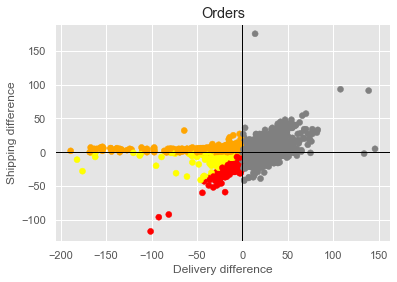

In [34]:
plot_late_order(delivered_orders)

1. **Grey points**: order was delivered on time
2. **Orange points**: order was late because of the logistic firm
3. **Yellow points**: order was late because of the seller
4. **Red points**: order was late because of both the seller and the logistic firm

In [35]:
delivered_orders[delivered_orders['delivery_difference']<0]

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon,delivery_difference,shipping_difference
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,633ecdf879b94b5337cca303328e4a25,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-09-25 04:04:09,2017-10-09 22:23:46,2017-09-28,109.90,1.0,8.96,-23.572939,-46.651115,-23.676570,-46.669897,-12,-12
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,c0563dd588b775f2e37747ef6ad6c92c,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-02-28 02:30:44,2018-03-21 22:03:54,2018-03-12,109.90,1.0,15.53,-22.879477,-43.440264,-23.622288,-46.536901,-10,1
36,8563039e855156e48fccee4d611a3196,5f16605299d698660e0606f7eae2d2f9,955fee9216a65b617aa5c0531780ce60,2018-02-17 15:59:46,2018-02-17 16:15:34,2018-02-20 23:03:56,2018-02-22 15:15:34,2018-03-20 00:59:25,2018-03-20,78.00,1.0,28.95,-12.478669,-49.122905,-23.691013,-46.703810,-1,1
42,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-11-30 00:21:09,2017-12-28 18:59:23,2017-12-21,339.00,1.0,17.12,-21.874288,-51.844970,-27.231416,-49.657477,-8,-14
58,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,db4350fd57ae30082dec7acbaacc17f9,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-03-15 15:30:45,2018-04-03 13:28:46,2018-04-02,45.98,2.0,22.85,-10.971622,-37.067341,-23.580395,-46.591326,-2,0
59,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,391fc6631aebcf3004804e51b40bcf1e,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-03-17 18:14:36,2017-04-06 13:37:16,2017-03-30,84.90,1.0,14.36,-22.863075,-47.149981,-21.757321,-48.829744,-8,-5
99,6a0a8bfbbe700284feb0845d95e0867f,68451b39b1314302c08c65a29f1140fc,4a3ca9315b744ce9f8e9374361493884,2017-11-22 11:32:22,2017-11-22 11:46:50,2017-11-27 13:39:35,2017-11-28 11:46:50,2017-12-28 19:43:00,2017-12-11,83.90,1.0,17.84,-22.896203,-43.312661,-21.757321,-48.829744,-18,0
104,a5474c0071dd5d1074e12d417078bbd0,ef15b3240b2083e0487762ee2978d2b8,fd386aa7bed2af3c7035c65506c9b4a3,2018-07-30 22:41:44,2018-08-01 02:50:15,2018-08-02 10:35:00,2018-08-03 02:50:15,2018-08-03 19:28:47,2018-08-02,13.99,1.0,7.39,-23.529917,-46.889261,-23.592776,-46.601191,-2,0
112,9d531c565e28c3e0d756192f84d8731f,d4faa220408c20e53595d2950f361f3b,903037660cf848a717166eb7a06d616e,2017-11-28 21:00:44,2017-12-01 09:31:15,2017-12-14 20:37:43,2017-12-06 20:57:24,2018-01-23 21:38:52,2017-12-22,25.99,1.0,14.10,-22.956593,-42.883494,-23.625699,-46.743468,-33,-8
117,8fc207e94fa91a7649c5a5dab690272a,c69f8b33e62ecb30ff78ae46d7fb9241,4a3ca9315b744ce9f8e9374361493884,2017-11-26 17:49:46,2017-11-26 17:58:34,2017-11-28 23:17:09,2017-11-30 17:58:34,2018-01-20 13:42:22,2017-12-19,109.90,1.0,25.61,-22.784016,-43.397032,-21.757321,-48.829744,-33,1


In [36]:
X = [x for x in delivered_orders.delivery_difference]
Y = [y for y in delivered_orders.shipping_difference]

grey_points = [i for i, x in enumerate(X) if (X[i]>=0)]
orange_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]>=0)]
yellow_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]<0) and (Y[i]>=X[i])]
red_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]<0) and (Y[i]<X[i])]

In [37]:
print(" %5.2f pct. of the orders was delivered on time" %((len(grey_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the logistic firm" %((len(orange_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the seller" %((len(yellow_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of both the seller and logistic firm" %((len(red_points)/len(X))*100))

 92.03 pct. of the orders was delivered on time
  5.78 pct. of the orders was delivered late because of the logistic firm
  1.34 pct. of the orders was delivered late because of the seller
  0.85 pct. of the orders was delivered late because of both the seller and logistic firm


# <font color='blue'>Part 2</font>: Prediction - Estimated delivery time

In [38]:
delivered_orders['actual'] = delivered_orders.order_delivered_customer_date - delivered_orders.order_purchase_timestamp
delivered_orders['actual'] = delivered_orders['actual'].dt.days

In [39]:
delivered_orders.actual.describe()

count    99678.000000
mean        12.021279
std          9.530233
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: actual, dtype: float64

In [40]:
delivered_orders.head()

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon,delivery_difference,shipping_difference,actual
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-06 11:07:15,2017-10-10 21:25:13,2017-10-18,29.99,1.0,8.72,-23.576983,-46.587161,-23.680729,-46.444238,7,1,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-07-30 03:24:27,2018-08-07 15:27:45,2018-08-13,118.70,1.0,22.76,-12.177924,-44.660711,-19.807681,-43.980427,5,3,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-13 08:55:23,2018-08-17 18:06:29,2018-09-04,159.90,1.0,19.22,-16.745150,-48.514783,-21.363502,-48.229601,17,4,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-11-23 19:45:59,2017-12-02 00:28:42,2017-12-15,45.00,1.0,27.20,-5.774190,-35.271143,-19.837682,-43.924053,12,1,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-19 20:31:37,2018-02-16 18:17:02,2018-02-26,19.90,1.0,8.72,-23.676370,-46.514627,-23.543395,-46.262086,9,5,2


# -------adding features--------

In [41]:
def geoDistance(lat0, lon0, lat1, lon1):
    # Approx. radius of earth (km)
    R = 6373.0 
    # Convert to radians
    lat0, lon0 = radians(lat0), radians(lon0)
    lat1, lon1 = radians(lat1), radians(lon1)
    
    # Getting differences
    dlon, dlat = lon1 - lon0, lat1 - lat0
    
    # Use haversine formula
    a = sin(dlat / 2)**2 + cos(lat0) * cos(lat1) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [42]:
delivered_orders['Distance'] = delivered_orders.apply(lambda row:\
    geoDistance(row['customer_lat'], row['customer_lon'], row['seller_lat'], row['seller_lon']), axis=1)

In [43]:
#https://www.weatherbit.io/api/weather-history-hourly

In [44]:
delivered_orders["estimated_delivery"] = (delivered_orders.order_estimated_delivery_date-delivered_orders.\
                                          order_purchase_timestamp).dt.total_seconds() / (24 * 60 * 60)

# -------adding features end--------

- take a look at what the actual delivery - the forecasted delivery was (have this as an error measure
- the forecast should be trained from the actual delivery time, and have this as the ideal model. If we can forecast exactly how much time it takes. 
- 

In [61]:


features = ['order_price','quantity','freight_value','customer_lat',
           'customer_lon','seller_lat','seller_lon','Distance','estimated_delivery']
target = ['actual']

X = np.array(delivered_orders[features])
y = np.array(delivered_orders['actual'])
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state=42)

# <font color='blue'>2.2</font>: Establish baseline

# --------plot denne for bedste model også--------

In [62]:
#Creating variables for both actual and estimated deliveries
actual_delivery = delivered_orders.actual
estimated_delivery = delivered_orders.estimated_delivery

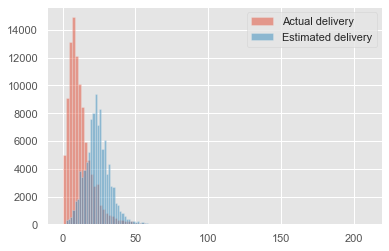

In [63]:
#Plotting actual delivery times and estimated delivery times
plt.hist(actual_delivery, bins= 100, alpha=0.5, label='Actual delivery')
plt.hist(estimated_delivery, bins= 100, alpha=0.5, label='Estimated delivery')
plt.legend(loc='upper right')
plt.show()

As can be seen from the plot above, Olist are systematically overestimating the delivery dates, which might give customers a motivation for shopping through another ecommerce, if they are estimating a faster delivery. 
Therefore, we want to enable a correct and much better estimated delivery time, so that the customer gets more correct information about the faster delivery of their products. 

##### How much is Olist wrong at the current state

In this cell, we are looking at the estimated time of delivery that Olist gives the customer upon purchase. We are then measuring what the error is on this estimate given to the customer. 

In [64]:
#Defining an array consisting of the estimated delivery times and the actual delivery times
Y_estimate = X_test[:,-1]
baseline_errors = np.sqrt(((Y_estimate - y_test) ** 2).mean())

print('Error in estimate to actual delivery: ', round(np.mean(baseline_errors), 2), 'days')

Error in estimate to actual delivery:  15.54 days


The last feature in the test and trining set was only included for the purpose of the above calculation and will this be removed.

In [65]:
#Removing the last column in x_train and x_test
X_test = X_test[:,:-1]
X_train = X_train[:,:-1]

##### Mean prediction

Predicting the average delivery time for all the orders. In this cell, we will look at how well a baseline model does, if we predict all the coming delivery times, to be the same as the average of all delivery times from our training set. This can act as a baseline, to see if the measure is actually a better prediction that the estimate Olist are currently able to provide.

In [66]:
#Creating a baseline predicting the average delivery time
Y_pred_baseline = y_train
Y_pred_baseline = np.mean(Y_pred_baseline)

baseline_errors = np.sqrt(((Y_pred_baseline - y_test) ** 2).mean())

print('Baseline RMSE error:', round(np.mean(baseline_errors), 2), 'days')

Baseline RMSE error: 9.71 days


The baseline model shows, that there is a potential to be significantly more correct in estimating the delivery times from just estimating the delivery time as the average actual delivery time in the training set. This poses the question, if we can significantly improve the estimate from using more advanced models, which rely on some of the features that we have available when a customer places an order. 

##### Linear regression model

At first, we will use a linear regression model to see if we can beat the baseline model. Furthermore, the linear regression model might indicate which features that has an impact on the estimated delivery time. 

In [93]:
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [94]:
#Defining and fitting a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train);

In [95]:
#Predicting the estimated delivery times and calculating the error
predictions = lr.predict(X_test)
errors = np.sqrt(((predictions - y_test) ** 2).mean())

print('RMSE for linear regression model: ', round(np.mean(errors), 2), 'days')

RMSE for linear regression model:  8.97 days


In [96]:
for i in range(len(lr.coef_)):
    print("Feature:","'",features[i],"'", "has the following impact on the estimate: ", lr.coef_[i])

Feature: ' order_price ' has the following impact on the estimate:  -7.561016248445488
Feature: ' quantity ' has the following impact on the estimate:  -25.240084640148968
Feature: ' freight_value ' has the following impact on the estimate:  18.388682260745174
Feature: ' customer_lat ' has the following impact on the estimate:  69.71643611453861
Feature: ' customer_lon ' has the following impact on the estimate:  60.297130777581025
Feature: ' seller_lat ' has the following impact on the estimate:  -67.68889627320088
Feature: ' seller_lon ' has the following impact on the estimate:  -34.027688053696025
Feature: ' Distance ' has the following impact on the estimate:  -4.468588690770502


We see that this model performs slightly better than the baseline. Furthermore, we get an idea about which features that play an important role for the eatimate of the delivery. Here price and distance is the least important features, while seller latitude and customer latitude is the most important featuers. 

# Mangler: beskrivelse af FFNN samt kort opsamling op betydning af features

##### FFNN

In [97]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [106]:
#Defining input
input_ = X_train.shape[1]

#Defining model
model = Sequential()
model.add(Dense(20, input_dim=input_, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(50, input_dim=20, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='linear'))
#Specifying what type of loss function and optimizer to use:
model.compile(loss=root_mean_squared_error, optimizer='adam')

#model.fit(X_train, y_train, epochs=10, batch_size=16)
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test,y_test))

Train on 69774 samples, validate on 29904 samples
Epoch 1/15
69774/69774 [==============================] - 2s 28us/step - loss: 9.5575 - val_loss: 8.5317
Epoch 2/15
69774/69774 [==============================] - 2s 31us/step - loss: 8.7054 - val_loss: 8.3803
Epoch 3/15
69774/69774 [==============================] - 3s 41us/step - loss: 8.5584 - val_loss: 8.3768
Epoch 4/15
69774/69774 [==============================] - 2s 30us/step - loss: 8.5125 - val_loss: 8.3543
Epoch 5/15
69774/69774 [==============================] - 3s 50us/step - loss: 8.4593 - val_loss: 8.3193A: 2s -  - ETA: 0s - loss: 8.459
Epoch 6/15
69774/69774 [==============================] - 2s 34us/step - loss: 8.4264 - val_loss: 8.3165
Epoch 7/15
69774/69774 [==============================] - 3s 38us/step - loss: 8.3870 - val_loss: 8.2960
Epoch 8/15
69774/69774 [==============================] - 2s 34us/step - loss: 8.3748 - val_loss: 8.3143
Epoch 9/15
69774/69774 [==============================] - 2s 26us/step - loss:

Explain why `val_loss` is lower than `loss`: https://forums.fast.ai/t/validation-loss-lower-than-training-loss/4581

dict_keys(['val_loss', 'loss'])


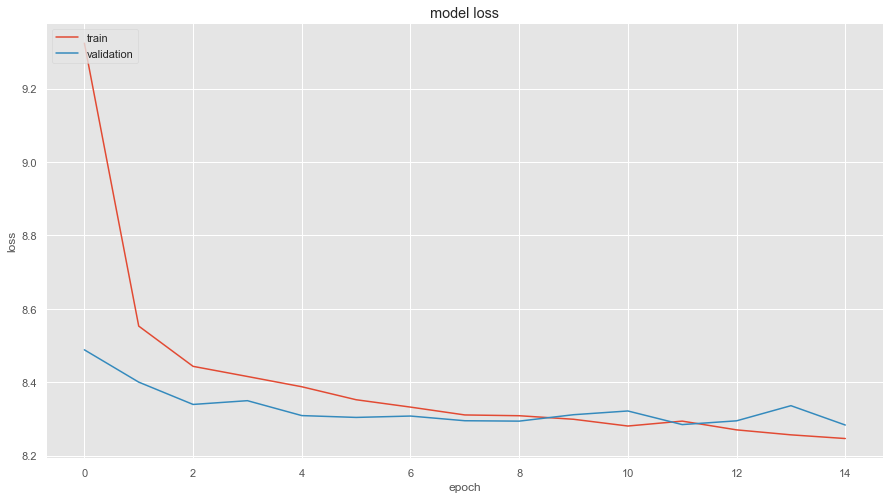

In [99]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train error', 'Validation error'], loc='upper right')
plt.show()

In [101]:
#Predicting the 
pred = model.predict(X_test)
baseline_errors = np.sqrt(np.mean((pred - y_test) ** 2))
print('Baseline RMSE error:', round(np.mean(baseline_errors), 2), 'days')

Baseline RMSE error: 10.43 days


# Jens-------------

Spørg jensen:
- nedenstående tager laver en y_baseline, der er lige så lang som y_train. Men denne Y_baseline består af tallene fra "delivery difference" - dette skal vel være actual, når vi prøver at forudsige den faktiske delivery dato. 

In [ ]:
baseline_preds = delivered_orders['delivery_difference'].values
X_baseline = baseline_preds[:69774]
Y_baseline = baseline_preds[69774:]

baseline_errors = abs(Y_baseline - y_test)

print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'days')

In [ ]:


lr = LinearRegression()

lr.fit(X_train, y_train)

In [ ]:
predictions = lr.predict(X_test)

errors = abs(predictions - y_test)

print('Average baseline error: ', round(np.mean(errors), 2), 'days')

In [ ]:
mape = 100 * (errors/y_test)

accuracy = 100 - np.mean(mape)

print('Accuracy: ', round(accuracy, 2), '%')

In [ ]:
errors

In [ ]:
mape

# Jens-------------

# <font color='blue'>Part 3</font>: Prediction - Late delivery (yes or no)

This last analysis will seek to predict whether a delivery will be late or not. An online retailer platform like Olist can benefit from this analysis in several different ways: First, simply knowing which factors affect the delivery of orders is useful. Secondly, having this model deployed Olist would be able to warn sellers and customers when a order was predicted to be delivered late. 

his parameter setting means that the penalties for false predictions in the loss function will be weighted with inverse proportions to the frequencies of the classes. This can solve the problem you describe

This model will use logistic regression to perfrom the binary classification, where the the target variable $y$ is defined as: 1 if the order was delivered on time and 0 if it was late. T

In [197]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np

X = delivered_orders[['quantity','order_price','freight_value','Distance','customer_lat','customer_lon','seller_lat', 'seller_lon']]
X = preprocessing.StandardScaler().fit_transform(X)

y = (delivered_orders.order_estimated_delivery_date > delivered_orders.order_delivered_customer_date).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [198]:
y.value_counts()

1    91734
0     7943
dtype: int64

In [199]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial', class_weight='balanced').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.11      0.49      0.19      2619
           1       0.94      0.67      0.79     30275

    accuracy                           0.66     32894
   macro avg       0.53      0.58      0.49     32894
weighted avg       0.87      0.66      0.74     32894



In [200]:
name = ['quantity','order_price','freight_value','Distance','customer_lat','customer_lon','seller_lat', 'seller_lon']
coef = clf.coef_[0]

In [201]:
list(zip(name,coef))

[('quantity', 0.028618855909278738),
 ('order_price', -0.011055484519004453),
 ('freight_value', -0.027559249760767204),
 ('Distance', -0.10019226193750153),
 ('customer_lat', 0.04987851673761936),
 ('customer_lon', -0.117464442040911),
 ('seller_lat', -0.03160464092741305),
 ('seller_lon', 0.0053219905992225635)]

Interpretation of coefficients: 
- Orders with larger quantity are more likely to be delivered on time. 
- Orders with longer distance between seller and customer are less likely to be delivered on time.
- Orders with a high customer longitude coordinate are less likely to be delivered on time.
close to coast 

Features that could prove useful to this model, but has not yet been implemented:
- Weather forcast data
- Historical weather data
- Real distance between seller and customer (on roads)
- Seller track record (in terms of number of previously late deliveries. 
- Seller reviews (average)


- Previously late delivery

In [202]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import pysal as ps
from pysal.viz.splot import mapping as maps

In [280]:
delivered_orders['late'] = y

late_orders = delivered_orders[delivered_orders.late == 0]
df = late_orders[['customer_lat','customer_lon']]
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.customer_lon, df.customer_lat))

orders = delivered_orders[delivered_orders.late == 1]
df1 = orders[['customer_lat','customer_lon']]
gdf1 = gpd.GeoDataFrame(
    df1, geometry=gpd.points_from_xy(df1.customer_lon, df1.customer_lat))

In [288]:
delivered_orders.groupby(['customer_lat','customer_lon']).agg({'late':'sum', 'customer_lat':'count'})

,,late,customer_lat
customer_lat,customer_lon,,
-33.689948,-53.460183,5.0,5
-33.512901,-53.349748,13.0,13
-32.561057,-53.378114,8.0,8
-32.235661,-53.078851,2.0,3
-32.195805,-52.180033,1.0,1
...,...,...,...
2.835272,-60.673422,3.0,3
2.846929,-60.712952,1.0,1
2.855558,-60.660713,3.0,3


In [253]:
# define color dictionary
color_map = {1:"blue", 0:'red'}

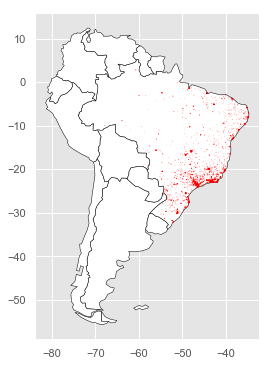

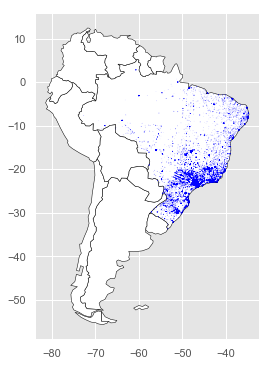

In [257]:
plt.rcParams['figure.figsize'] = [14, 6]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# restrict to South America.
ax1 = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

ax2 = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')


colors_late = [color_map[x] for x in late_orders['late']]
gdf.plot(ax=ax1, color=colors_late, alpha=0.3, markersize=.1)

colors = [color_map[x] for x in orders['late']]
gdf1.plot(ax=ax2, color=colors, alpha=0.1, markersize=.1)
plt.show()


# <font color='blue'>Part 4</font>: Clustering - Warehouse locations

# Conclusion

- Operationelle vi går ind og optimere på for at sikre god oplevelse under og efter køb
- Der er et problem givet at 8% forsinkelser over alle ordre
- Går ind og kigger på hvad vi deskriptivt kan udlede af årsager til forsinkelserne, finder at: (1) det i høj grad er logistikudbyderens skyld at varerne er forsinket. (2) I mindre del at tilfældene er det seller som ikke har varen parat når logistikudbyderen skal 'tage over' 
- Derefter kigger vi på den estimerede tid til delivery, som informeres om efter køb. Her kan vi se at Olist systematisk informerer om en langt højere leveringstid end den tid de faktisk bruger på at levere. Vi finder frem til at vi godt kan lære af data, og at de kan give langt mere præcise leveringsestimater ved brug af de modeller, som er lavet. 
- Sidst går vi ind og ser om vi kan flagge potentielt forsinkede ordre inden det sker. Her påvises også at forskellige modeller kan fange et signal om, om en ordre leveres til tiden. --> fremtidigt arbejde hertil kan være at prediktere den faktiske forsinkelse, såfremt modellen prediktere at en vare bliver forsinket. 


- (1) --> bedre forhandling af logistikaftaler, fx som pålægning af bøder ved for sen levering fra 3. part. 
- (2) --> kan løses ved eksempelvis varelagre og på
- (3) --> de nye og bedre estimater af leverancer kan både bruges til at tiltrække kunder og til at fastholde kunder 
- (4) --> beredskabspakke som ved flagget ordre kan tages i brug for at ændre udfaldet, samtidig med at kunden bliver informeret hurtigst muligt, med et nyt og præcist estimat for levering --> bliver dette gjort korrekt, så forbedre det også den første KPI (antal forsinkelser). 


